In [2]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/methods/")

%matplotlib inline

In [3]:
task_name = "center_hold"
subjects = analysis.load_subjects()

In [4]:
def load_raw_subject_movement_stack(subject):
    # session, trial, channel, time
    stack = np.empty(shape=(2,14,64,2000))
    stack[:] = np.nan
    lowpass_kernel = emg.make_kernel(750, 5.0, 2000, mode="lowpass")
    highpass_kernel = emg.make_kernel(250, 0.1, 2000, mode="highpass")
    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = analysis.get_movement_filenames("emg_olympics", subject.name, session_name)
        for bar_idx, filename in enumerate(filenames):
            e = analysis.load_movement_emg(filename)
            e = emg.filter_emg(e, subject.variance,lowpass_kernel=lowpass_kernel,highpass_kernel=highpass_kernel)
            assert e.shape[1] == 64, e.shape
            assert e.shape[0] > e.shape[1], e.shape
            stack[session_idx, bar_idx, :, :e.shape[0]] = e.T
    return np.array(stack)

def compute_cutoffs(subject_stack):
    # global cutoffs
    assert subject_stack.shape[2] == 64, subject_stack.shape
    samples = analysis.remove_nan_rows(subject_stack.transpose(0,1,3,2).reshape(-1,64))
    lognorms = np.log(np.linalg.norm(samples,axis=1))
    return (np.percentile(lognorms,1), np.percentile(lognorms,99.9))

def find_cutoff_mask(signal,cutoffs):
    # use this with single trials!
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    assert len(cutoffs) == 2
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mask = (cutoffs[0] < log_norm) * (log_norm < cutoffs[1])
    return np.arange(signal.shape[0])[mask]

def find_within_trial_mask(signal):
    # within trial values -- 30th percentile of log X
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mean_log_norm = np.mean(log_norm)
    std_log_norm = np.std(log_norm)
    # assuming large samples and rv being lognormal, this is roughly the 30th percentile
    mask = log_norm > (mean_log_norm - 0.5*std_log_norm)
    return np.arange(signal.shape[0])[mask]

def find_trial_filter_indices(signal, cutoffs):
    # combine filters
    assert signal.shape[1] == 64, signal.shape
    assert signal.shape[0] > signal.shape[1], signal.shape
    return np.array([i for i in range(signal.shape[0]) if ((i in find_within_trial_mask(signal)) and (i in find_cutoff_mask(signal, cutoffs)))])

# load and filter the data
def filter_subject_movement_stack(subject_stack):
    assert subject_stack.shape[2] == 64
    assert len(subject_stack.shape) == 4
    # session, trial, channel, time
    stack = np.zeros_like(subject_stack)
    stack[:] = np.nan
    cutoffs = compute_cutoffs(subject_stack)
    for session_idx, session_trials in enumerate(subject_stack):
        for trial_idx, e in enumerate(session_trials):
            assert e.shape[0] == 64, e.shape
            assert e.shape[1] > e.shape[0], e.shape
            e_without_nans = analysis.remove_nan_rows(e.T)
            if e_without_nans.shape[0] < e_without_nans.shape[1]:
                print(f"Empty trial: {session_idx,trial_idx}")
            else:
                indices = find_trial_filter_indices(e_without_nans,cutoffs)
                e = e[:,indices]
                # stuff this into stack array
                stack[session_idx, trial_idx, :, :e.shape[1]] = e
    return stack

## plot some raw EMG as an example

Figure saved to /Users/spencer/phd/phd/images/methods/raw_data.pdf


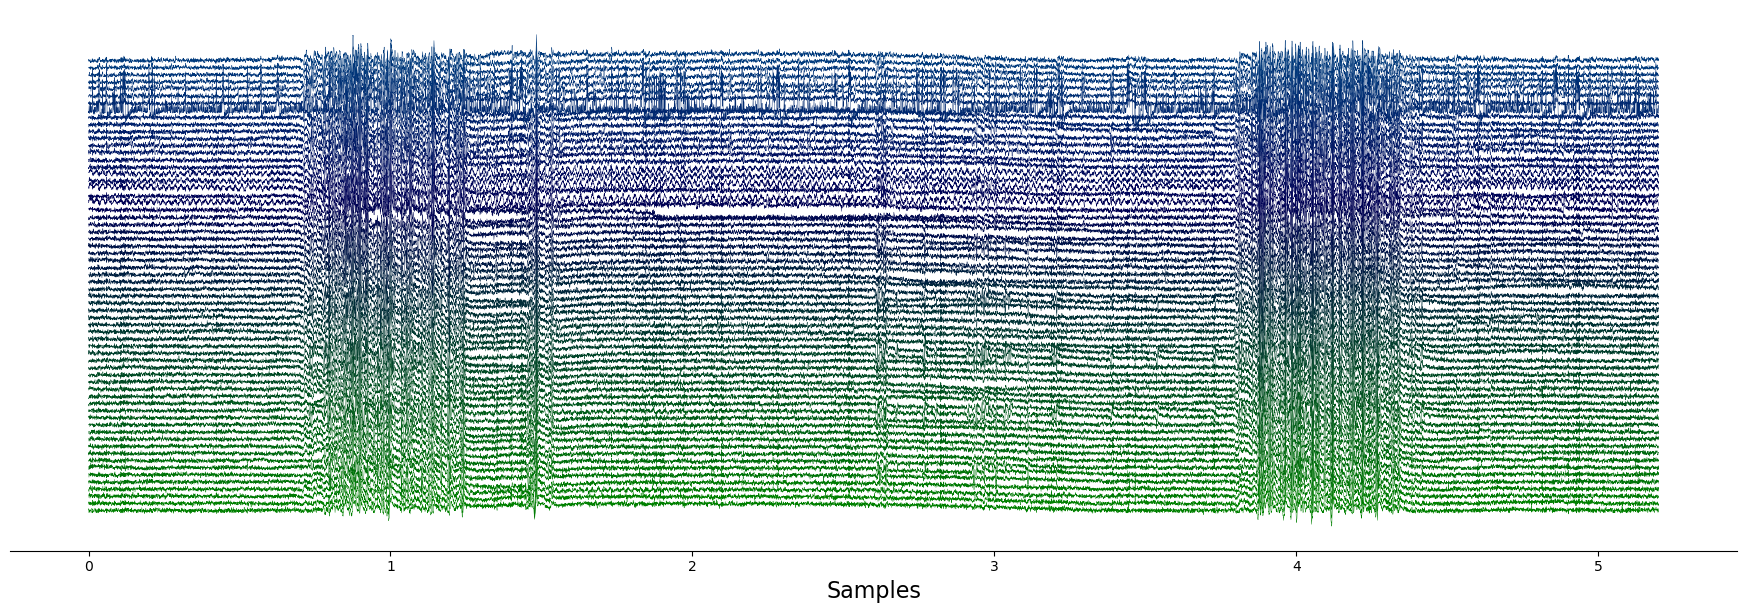

In [57]:
subject_idx = 1
filenames = analysis.get_movement_filenames("emg_olympics", subjects[subject_idx].name, "session_1")
e = analysis.load_movement_emg(filenames[0])
cmap = mpl.colormaps["ocean"]
fig, ax = plt.subplots(1,1,figsize=(18,6))
fig.tight_layout()
# channels = list(range(64))
for ch in range(64):
    # ci = np.random.choice(channels,replace=False)
    emg_to_plot = e[3200:-4400,ch]
    n_samples = emg_to_plot.shape[0]
    ax.plot(np.linspace(0,n_samples/2000,n_samples),emg_to_plot+ch*20,linestyle="-",marker="",color=cmap((ch//2)/64),linewidth=0.3)
# ax.set_xticks()
ax.set_yticks([])
ax.spines[["left"]].set_visible(False)
ax.set_xlabel("Samples")

plot.save_figure(fig,"raw_data",image_path)

## testing filtering to speed things up -- confirmed

In [27]:
def slow_filter_emg(a, var, lowpass_kernel=None, highpass_kernel=None):
    assert a.shape[1] == 64
    return emg.subsample(emg.lowpass(emg.rectify(emg.standardize(emg.highpass(a,highpass_kernel), var)),lowpass_kernel))

## confirm recorded filtered trial matches post-hoc filtered data

(11550, 64) (1156, 64)


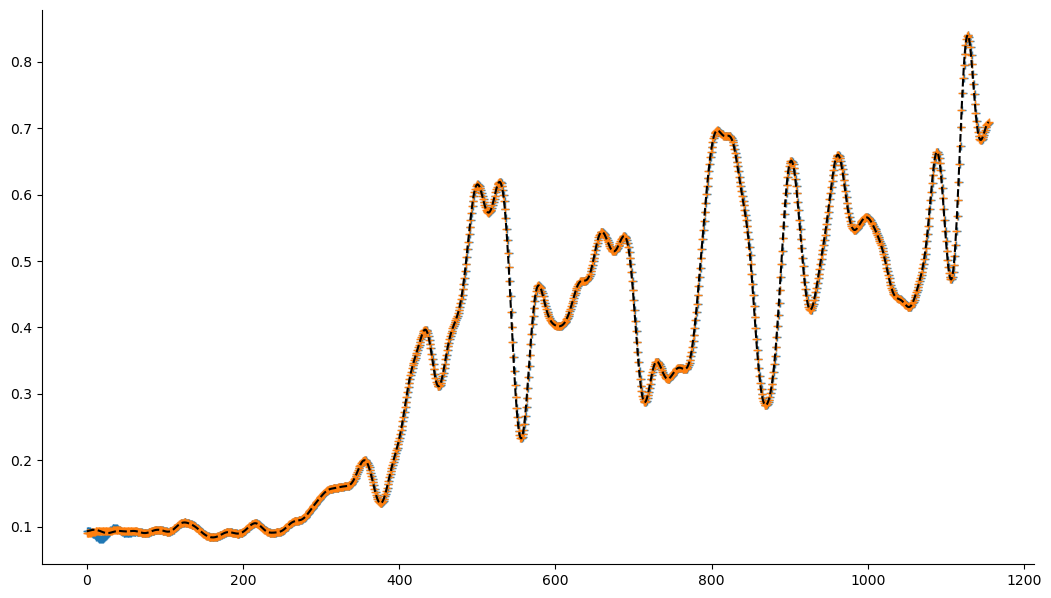

In [28]:
subject_idx = 4
session_idx = 5
trial_idx = 3
trial = subjects[subject_idx].tasks[task_name].sorted_sessions()[session_idx].sorted_trials()[trial_idx]
ef = trial.get_filtered_emg()
er = trial.get_raw_emg()[:,:64]

ch = 16 

eo = slow_filter_emg(er,subjects[subject_idx].variance)
e_new_filter = emg.filter_emg(er,subjects[subject_idx].variance)
print(er.shape, e_new_filter.shape)

# plt.figure()
# for ch in range(64):
#     plt.plot(er[:,ch])

plt.figure()
plt.plot(ef[:,ch])
plt.plot(eo[:,ch])
plt.plot(e_new_filter[:,ch],"k--")

## illustrate filtering steps

In [92]:
ef.shape

(702, 64)

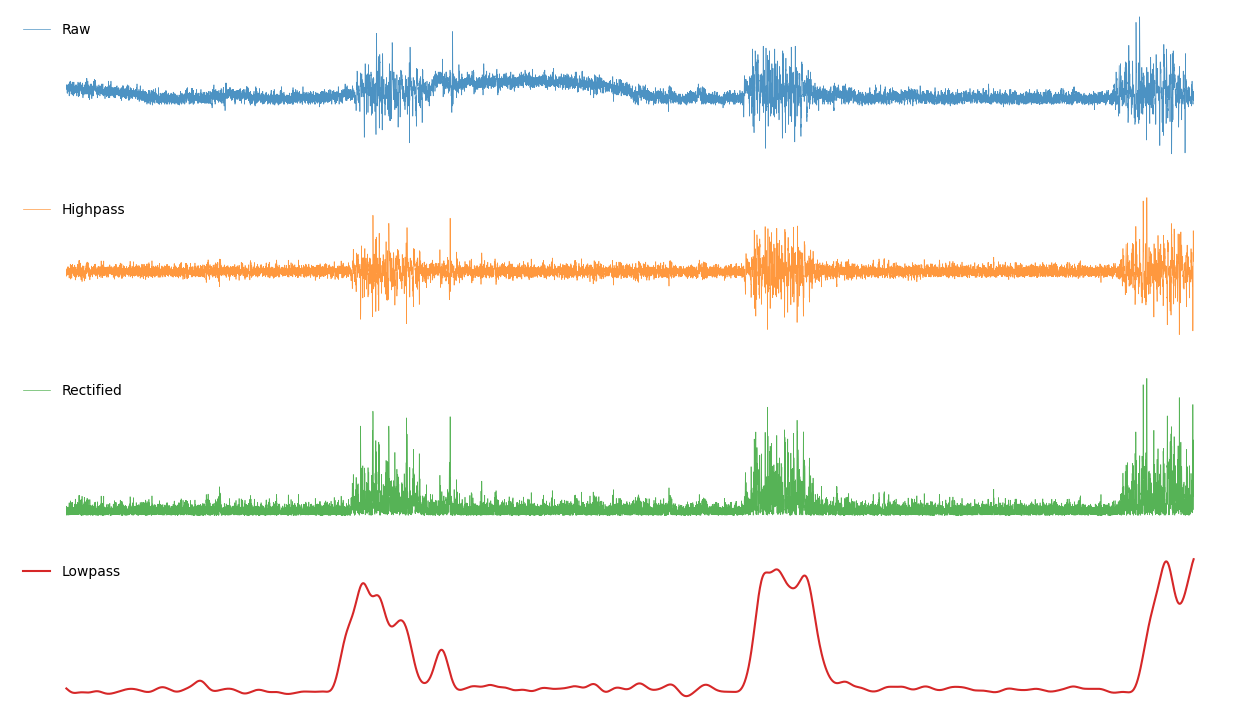

In [124]:
# trial = subjects[subject_idx].tasks[task_name].sorted_sessions()[1].sorted_trials()[1]
# var = subjects[subject_idx].variance
# ef = trial.get_filtered_emg()
# e = trial.get_raw_emg()[:,:64]

filenames = analysis.get_movement_filenames("emg_olympics", subjects[subject_idx].name, "session_1")
e = analysis.load_movement_emg(filenames[0])

fig, axes = plt.subplots(4,1,figsize=(16,9))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

reflected = np.concatenate([e[:1000][::-1], e],axis=0)
axes[0].plot(e[:,ch],alpha=0.8,label="Raw",linestyle="-",marker="",linewidth=0.5,color=colors[0])
lh = axes[0].legend(loc=2)
lh.set_frame_on(False)

# hp = emg.standardize(emg.fast_highpass(reflected),var)
hp = emg.fast_highpass(reflected)
axes[1].plot(hp[1000:,ch],alpha=0.8,label="Highpass",linestyle="-",marker="",linewidth=0.5,color=colors[1])
lh = axes[1].legend(loc=2)
lh.set_frame_on(False)

r = emg.rectify(hp)
axes[2].plot(r[1000:,ch],label="Rectified",alpha=0.8,linestyle="-",marker="",linewidth=0.5,color=colors[2])
lh = axes[2].legend(loc=2)
lh.set_frame_on(False)

lp = emg.subsample(emg.fast_lowpass(r))
axes[3].plot(lp[100:,ch],label="Lowpass",alpha=1,linestyle="-",marker="",linewidth=1.5,color=colors[3])
lh = axes[3].legend(loc=2)
lh.set_frame_on(False)

# axes[4].plot(ef[100:,ch],label="Recorded",alpha=1,linestyle="-.",marker="",linewidth=1.5)
# axes[4].legend(loc=2)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["left","bottom"]].set_visible(False)


In [125]:
plot.save_figure(fig,"filtering_steps",image_path)

Figure saved to /Users/spencer/phd/phd/images/methods/filtering_steps.pdf


## build movement data stack -- raw and filtered

In [15]:
subject_movement_stacks = []
subject_raw_movement_stacks = []
for subject_idx, subject in enumerate(subjects):
    print("Loading subject ", subject_idx)
    raw_stack = load_raw_subject_movement_stack(subject)
    subject_raw_movement_stacks += [raw_stack]
    subject_movement_stacks += [filter_subject_movement_stack(raw_stack)]
subject_raw_movement_stacks = np.array(subject_raw_movement_stacks)
subject_movement_stacks = np.array(subject_movement_stacks)
print(subject_raw_movement_stacks.shape,subject_movement_stacks.shape)

Loading subject  0
Loading subject  1
Loading subject  2
Loading subject  3
Loading subject  4
Loading subject  5
Loading subject  6
Loading subject  7
Loading subject  8
Loading subject  9
Loading subject  10
Loading subject  11
Loading subject  12
Loading subject  13
Loading subject  14
Loading subject  15
Loading subject  16
Loading subject  17
Loading subject  18
Loading subject  19
Loading subject  20
Loading subject  21
Loading subject  22
Empty trial: (0, 0)
Empty trial: (0, 1)
Empty trial: (0, 2)
Empty trial: (0, 3)
Empty trial: (0, 4)
Empty trial: (0, 5)
Empty trial: (0, 6)
Empty trial: (0, 7)
Empty trial: (0, 8)
Empty trial: (0, 9)
Empty trial: (0, 10)
Empty trial: (0, 11)
Empty trial: (0, 12)
Empty trial: (0, 13)
Loading subject  23
Loading subject  24
Loading subject  25
Loading subject  26
Loading subject  27
Loading subject  28
Loading subject  29
Loading subject  30
Loading subject  31
Loading subject  32
Loading subject  33
Loading subject  34
Loading subject  35
Loadin

## save it to disk!

In [16]:
# np.save("subject_filtered_movement_stacks.npy", subject_movement_stacks)
# np.save("subject_raw_movement_stacks.npy", subject_raw_movement_stacks)

## test loading

In [5]:
subject_movement_stacks = np.load("../subject_filtered_movement_stacks.npy")
subject_raw_movement_stacks = np.load("../subject_raw_movement_stacks.npy")
subject_movement_stacks.shape, subject_raw_movement_stacks.shape

((46, 2, 14, 64, 2000), (46, 2, 14, 64, 2000))

## inspect natural data for a test subject

In [44]:
# test stepping through raw data
subject_idx = 32
subject = subjects[subject_idx]
session_idx = 1
trial_idx = 11
e = analysis.remove_nan_rows(subject_raw_movement_stacks[subject_idx,session_idx,trial_idx,:,:].T)
cutoffs = compute_cutoffs(subject_movement_stacks[subject_idx])
indices = find_trial_filter_indices(e,cutoffs)

## inspect EMG signal

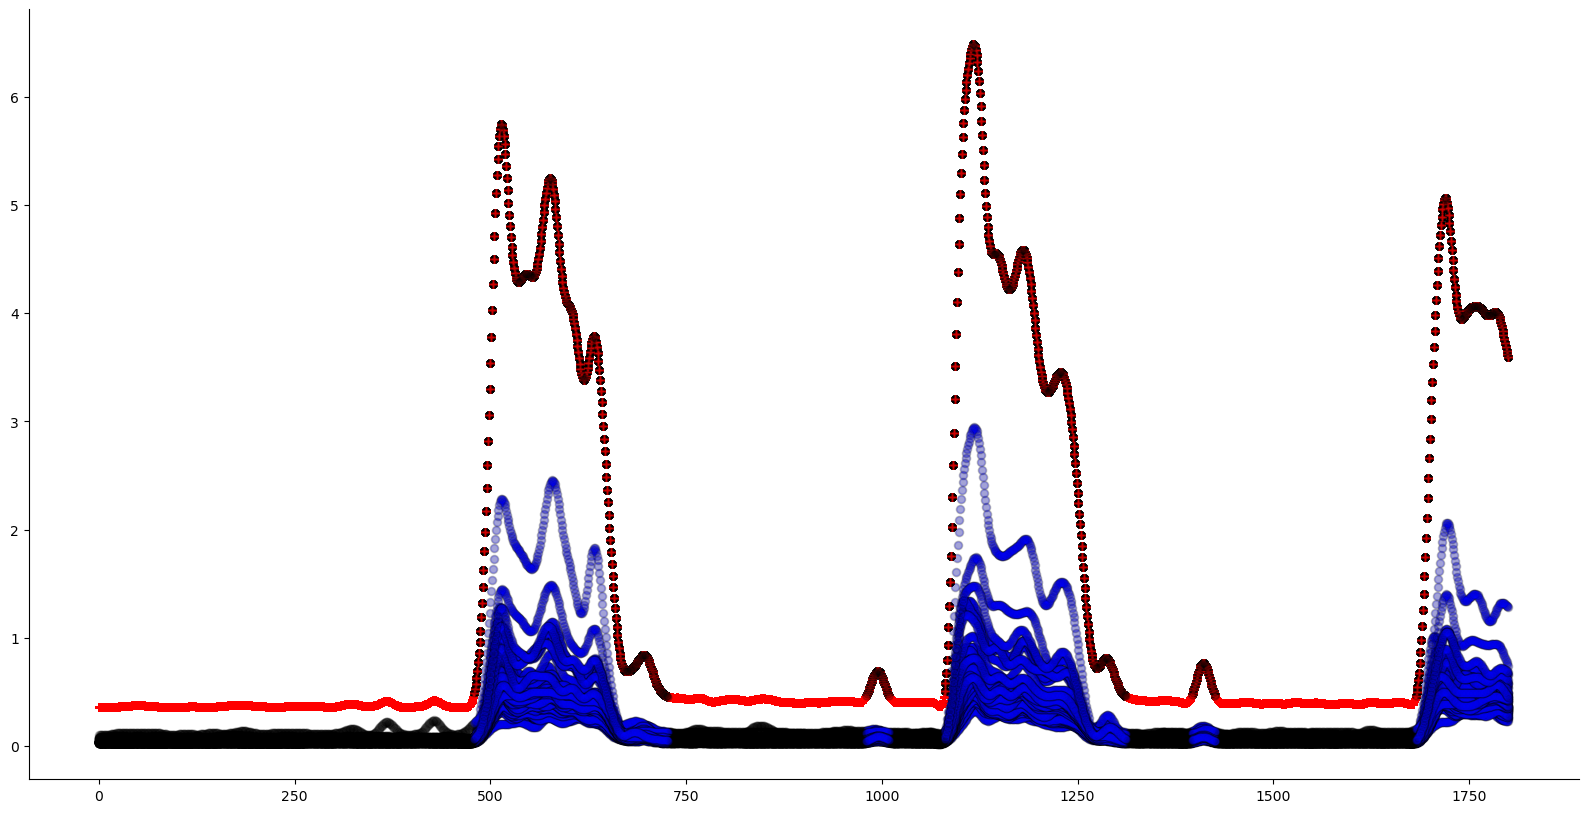

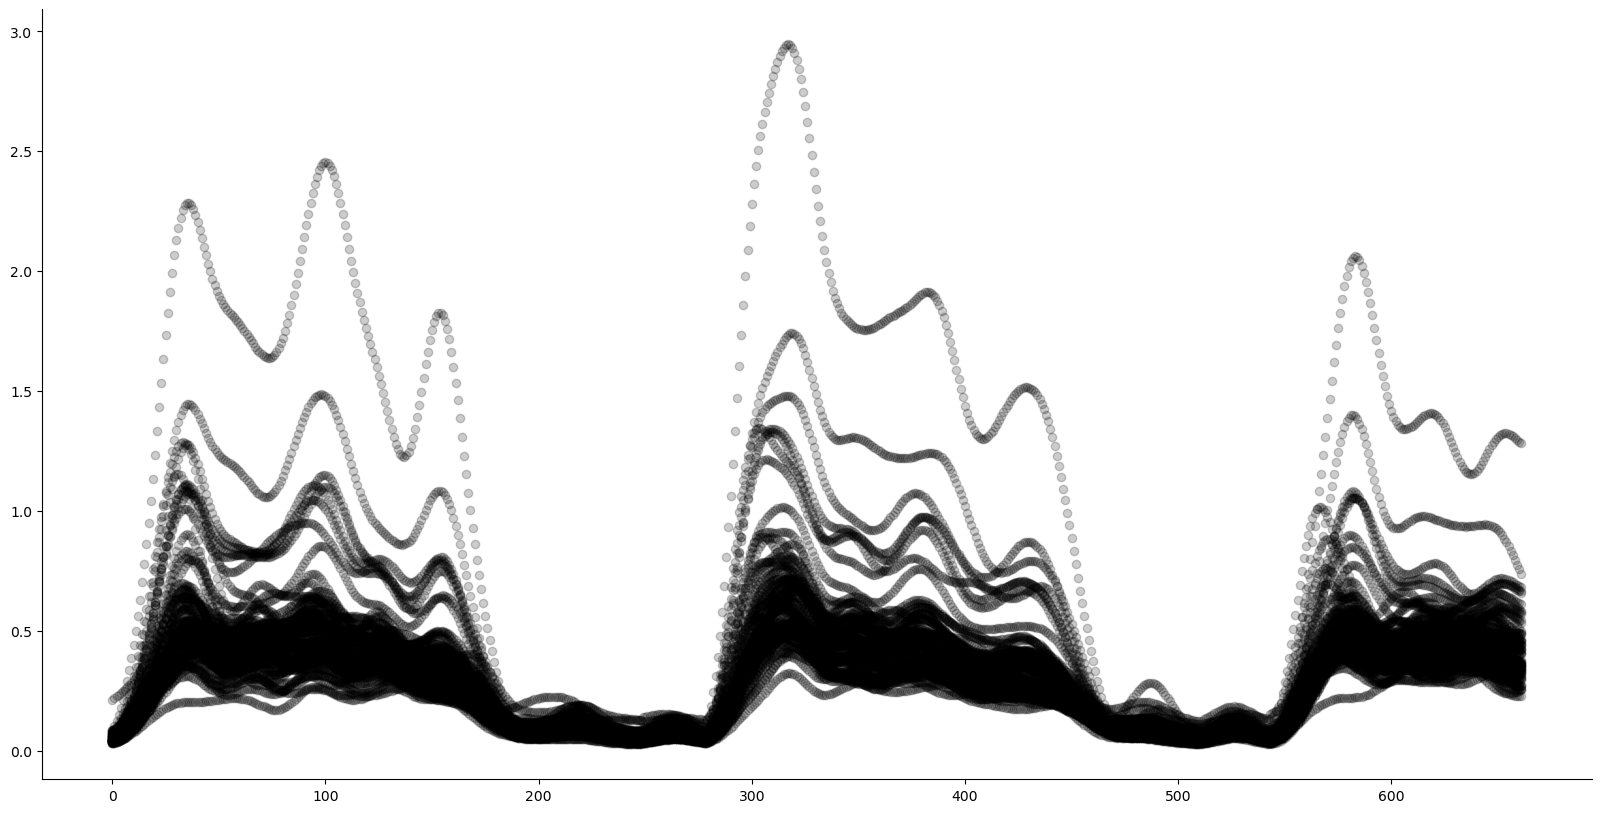

In [45]:
plt.figure(figsize=(20,10))
for ch in range(64):
    plt.plot(e[:,ch],'ko',alpha=0.2)
    plt.plot(indices, e[indices,ch],'bo',alpha=0.2,markersize=5)
    plt.plot(np.linalg.norm(e,axis=1),"r",)
    plt.plot(indices,np.linalg.norm(e,axis=1)[indices],"ko",alpha=0.2,markersize=5)
plt.figure(figsize=(20,10))
for ch in range(64):    
    plt.plot(subject_movement_stacks[subject_idx,session_idx,trial_idx,ch],'ko',alpha=0.2)

(662,)


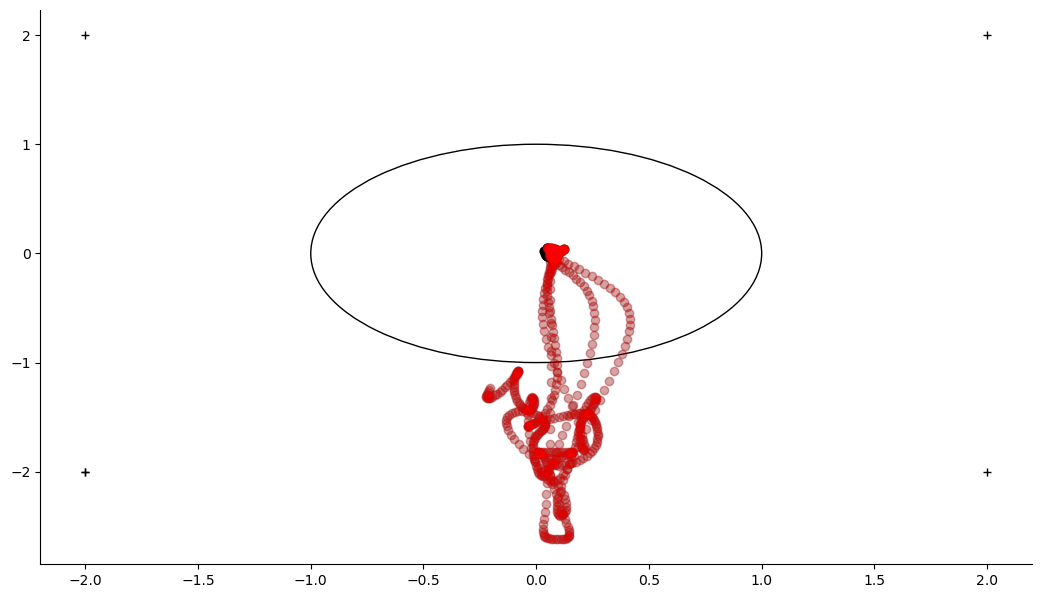

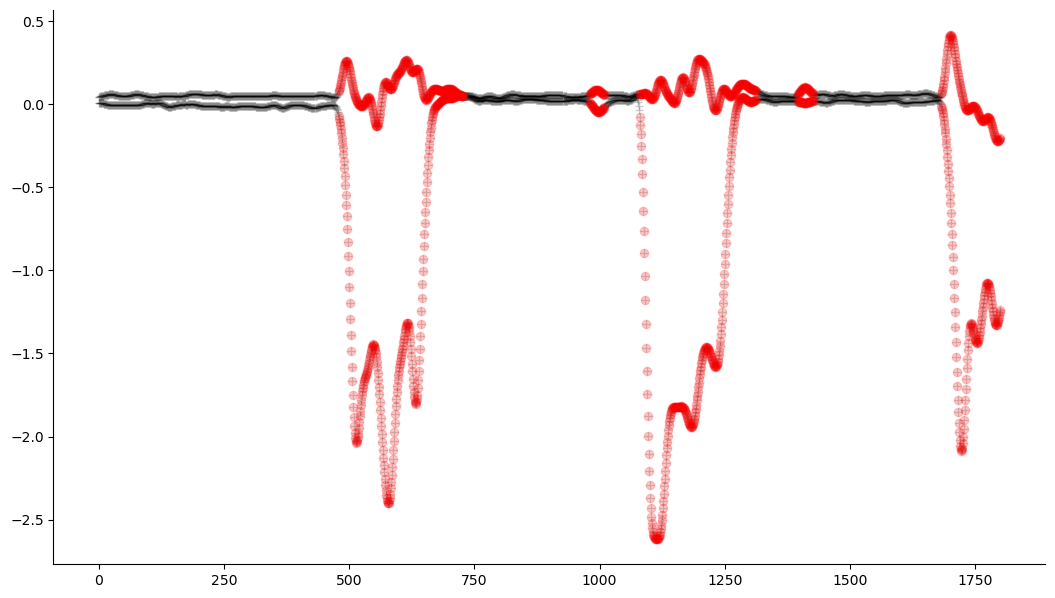

In [46]:
d = subject.decoder[-2:,:]
t = d @ e.T
print(indices.shape)
plt.figure()
plt.plot(t[0],t[1],"ko",alpha=0.2)
plt.plot(t[0,indices],t[1,indices],"ro",alpha=0.2)
l = 2
plt.plot([-l,-l,l,l,-l],[-l,l,l,-l,-l],'k')
c = plt.Circle([0,0],1,color="k",fill=None)
plt.gca().add_patch(c)

plt.figure()
plt.plot(t[0],'k',alpha=0.2)
plt.plot(t[1],'k',alpha=0.2)
plt.plot(indices,t[0,indices],'ro',alpha=0.2)
plt.plot(indices,t[1,indices],'ro',alpha=0.2)

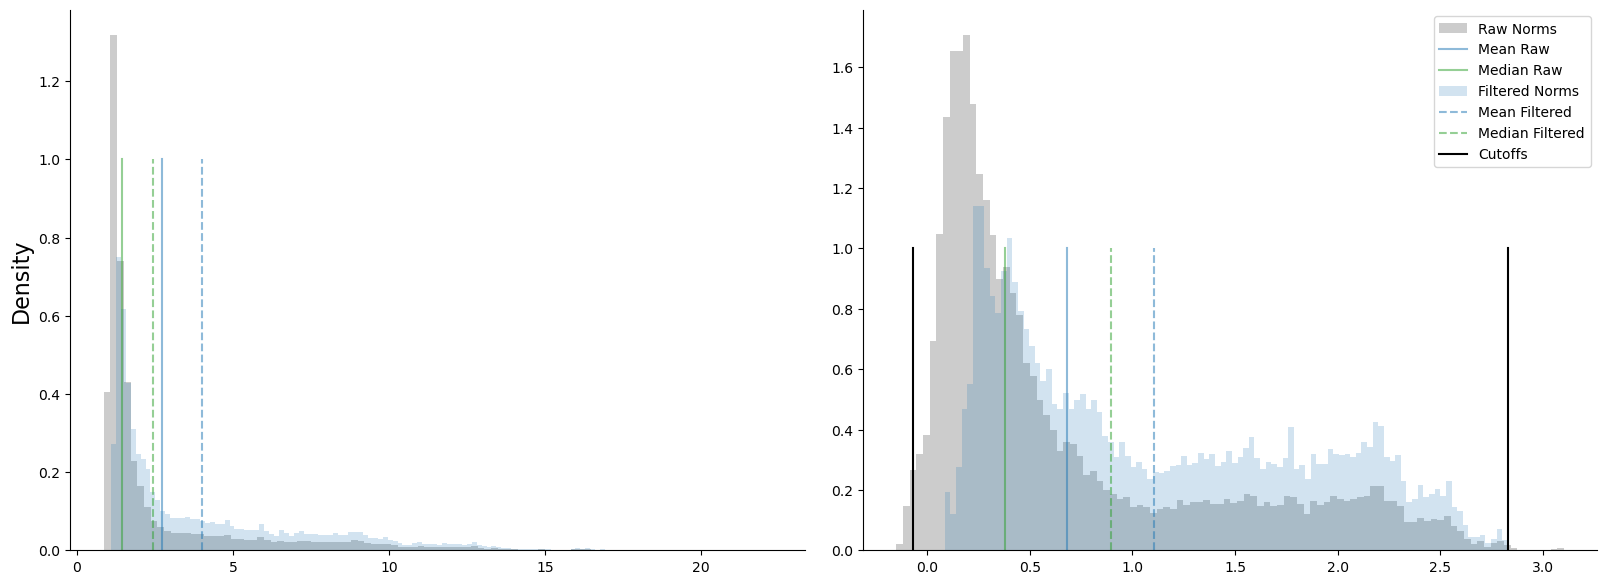

In [6]:
subject_idx = 1

cutoffs = compute_cutoffs(subject_raw_movement_stacks[subject_idx])

fig, axes = plt.subplots(1,2,figsize=(16,6))
fig.tight_layout()

raw_samples = analysis.remove_nan_rows(subject_raw_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))
filtered_samples = analysis.remove_nan_rows(subject_movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64))

raw_norms = np.linalg.norm(raw_samples,axis=1)
filtered_norms = np.linalg.norm(filtered_samples,axis=1)
raw_log_norms = np.log(np.linalg.norm(raw_samples,axis=1))
filtered_log_norms = np.log(np.linalg.norm(filtered_samples,axis=1))

def plot_stats(signal, ax, linestyle="-", label="", **kwargs):
    mean = np.mean(signal)
    ax.plot([mean, mean], [0,1],'tab:blue',linestyle=linestyle,label="Mean " + label,alpha=0.5, marker="",**kwargs)
    median = np.median(signal)
    ax.plot([median, median], [0,1],'tab:green',linestyle=linestyle,label="Median " + label,alpha=0.5, marker="",**kwargs)

# sample norms
axes[0].hist(raw_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
plot_stats(raw_norms, axes[0],label=" Raw")
# filtered norms
axes[0].hist(filtered_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
plot_stats(filtered_norms,axes[0],linestyle="--",label="Filtered")
# axes[0].legend()
# axes[0].set_xlabel("EMG Norm")
axes[0].set_ylabel("Density")

# sample norms
axes[1].hist(raw_log_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
plot_stats(raw_log_norms, axes[1],label="Raw")
# filtered norms
axes[1].hist(filtered_log_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
plot_stats(filtered_log_norms,axes[1],linestyle="--",label="Filtered")

axes[1].plot([cutoffs[0],cutoffs[0]],[0,1],"k-")
axes[1].plot([cutoffs[1],cutoffs[1]],[0,1],"k-",label="Cutoffs")

axes[1].legend(ncols=1,loc=1)
# axes[1].set_xlabel("Log of EMG Norm")
# axes[1].set_ylabel("Density")
# print(stats.normaltest(filtered_log_norms))

In [7]:
plot.save_figure(fig,"log_hist_movement",image_path)

Figure saved to /Users/spencer/phd/phd/images/methods/log_hist_movement.pdf
